In [1]:
import numpy as np
import pandas as pd
import re,os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import train_test_split

In [2]:
import pickle

with open('/home/bruce1996/data/LIHC_anomaly_detection/data/coding_gene_info/hgnc2ensembl.pkl' ,'rb') as f :
    hgsc_dict = pickle.load(f)
ens2hgsc = dict(zip(hgsc_dict.values(),hgsc_dict.keys()))

def voted_gene_list(gene_list,vote_number,threshold) :
    gene_l = np.array(gene_list)
    voted_idx =  vote_number > threshold
    return gene_l[voted_idx]

In [8]:
vote_result = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/vote_result/normal_only_std_by_gene_vote_np_ratio_15.txt',sep='\t',index_col=0)
coding_gene_idx = [bool(re.search('Synthetic',x)) == False for x in vote_result.index]
coding_gene = vote_result.index[coding_gene_idx]
hallmark = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/data/hallmark_gene/hallmark_protein_coding_ens_id.txt',sep='\t')
hallmark_gene = hallmark['EnsID'].values
non_hallmark_gene = list(set(coding_gene) - set(hallmark_gene))

In [9]:
exp_profile = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/data/exp_profile/LIHC_coding_gene_fpkm.txt',sep='\t',index_col=0)
scaler = StandardScaler()
std_x = scaler.fit_transform(exp_profile.T.to_numpy())
exp_m = pd.DataFrame(std_x.T,index=exp_profile.index,columns=exp_profile.columns)

In [14]:
non_hallmark_vote_result = vote_result.loc[non_hallmark_gene,:]
voted_gene = voted_gene_list(non_hallmark_vote_result.index,non_hallmark_vote_result['Vote'].values,900)
hallmark_m = exp_m.loc[hallmark_gene,:].T.to_csv('/home/bruce1996/data/LIHC_anomaly_detection/voted_gene_cca/test_cca_result_hallmark.txt',sep='\t')
voted_m = exp_m.loc[voted_gene,:].T.to_csv('/home/bruce1996/data/LIHC_anomaly_detection/voted_gene_cca/test_cca_result_voted.txt',sep='\t')

In [53]:
def cca_by_voted(non_hallmark_vote_result,hallmark_gene,exp_matrix,threshold) :

    voted_gene = voted_gene_list(non_hallmark_vote_result.index,non_hallmark_vote_result['Vote'].values,threshold)
    hallmark_m = exp_matrix.loc[hallmark_gene,:].T.to_numpy()
    voted_m = exp_matrix.loc[voted_gene,:].T.to_numpy()
    #calculated CCA
    n_comps = min(hallmark_m.shape[1], voted_m.shape[1])
    cca_score = np.zeros(2)
    cca = CCA(n_components=n_comps,scale=False,max_iter=2000)
    hallmark_t, voted_t = cca.fit_transform(hallmark_m,voted_m)
    cca_score[0] = np.corrcoef(hallmark_t[:,0],voted_t[:,0])[0,1]
    if n_comps > 1 :
        cca_score[1] = np.corrcoef(hallmark_t[:,1],voted_t[:,1])[0,1]
    return cca_score

In [ ]:
threshold = np.arange(1,1001)
cca_score = np.zeros([len(threshold),2])
n_vote_gene = np.zeros(len(threshold))
conditions = ['tumor_only','normal_only','hbv_only','nonhbv_only']
np_ratio = [25,15,20,20]
for c_idx,con in enumerate(conditions) :
    vote_result = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/vote_result/%s_std_by_gene_vote_np_ratio_%d.txt' % (con,np_ratio[c_idx]),sep='\t',index_col=0)
    non_hallmark_vote_result = vote_result.loc[non_hallmark_gene,:]
    for idx,th in enumerate(threshold) :
        voted_gene = voted_gene_list(non_hallmark_vote_result,non_hallmark_vote_result['Vote'].values,th)
        if len(voted_gene) == 0 :
            print("Without any nonhallmark gene vote number above %s" % th)
            break
        else :
            n_vote_gene[idx] = len(voted_gene)

        cca_result = cca_by_voted(non_hallmark_vote_result,hallmark_gene,exp_m,th) 
        if len(cca_result) < 2 :
            cca_score[idx,0] = cca_result[0]
        else :
            cca_score[idx,:] = cca_result

        if idx % 100 == 0 and idx > 0 :
            print("CCA complete %d iterations !" % idx)

    voted_gene_cca_result =pd.DataFrame({'n_voted_genes' : n_vote_gene,'CCA_coef1' : cca_score[:,0],'CCA_coef2' : cca_score[:,1],'Threshold' : threshold}) 
    voted_gene_cca_result.to_csv('/home/bruce1996/data/LIHC_anomaly_detection/voted_gene_cca/%s_cca_result.txt' % con,sep='\t')

In [5]:
def cca_coef_2axis_plot(cca_result,title,fig_output,ylim=[-1,1]) :

    fig, ax1 = plt.subplots(figsize = (8,5))
    threshold = cca_result['Threshold'].values
    cca_coef1 = cca_result['CCA_coef1'].values
    cca_coef2 = cca_result['CCA_coef2'].values
    n_vote_gene = cca_result['n_voted_genes'].values
    ax2 = ax1.twinx()
    cca_plot = ax1.plot(threshold, cca_coef1, color = '#7DB9B6',label = 'CCA coef1')
    cca2_plot = ax1.plot(threshold, cca_coef2, color = '#FFAACF',label = 'CCA coef2')
    n_gene_plot = ax2.plot(threshold, n_vote_gene, '-',label = 'n voted genes')
    '''
    ax1.hlines(max(cca_coef1),1,1000,colors='orange',linewidth=0.5,linestyles='--')# type: ignore    
    ax1.text(200,max(cca_coef1),"max CCA coef : %0.2f" % max(cca_coef1))
    '''

    # added these three lines
    lns = cca_plot + cca2_plot + n_gene_plot
    labs = [l.get_label() for l in lns]
    ax1.legend(lns,labs,loc=3)

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('CCA coef')
    ax1.set_title(title)
    ax1.set_ylim(ylim)
    ax2.set_ylabel('Number of non-hallmark voted gene', color='b')
    plt.savefig(fig_output,dpi=300,bbox_inches='tight')


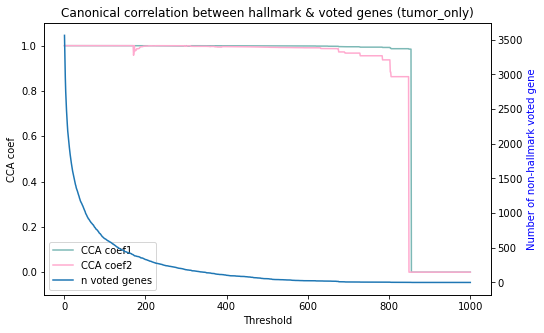

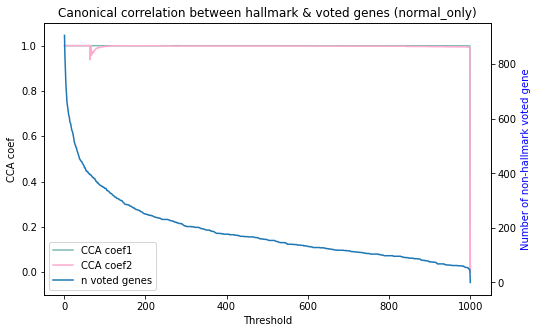

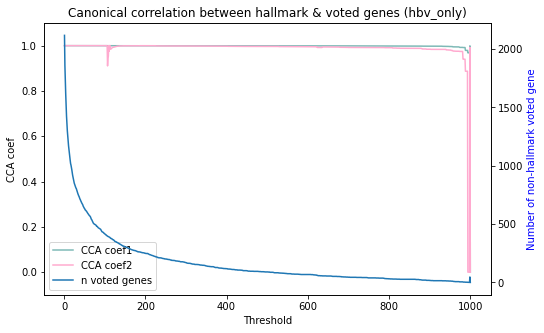

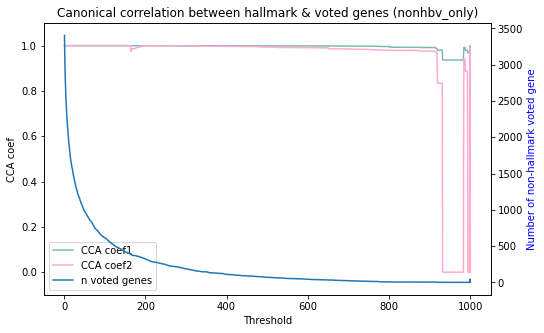

In [7]:
conditions = ['tumor_only','normal_only','hbv_only','nonhbv_only']
fig_output = '/home/bruce1996/data/LIHC_anomaly_detection/fig/canonical_correlation/'
cca_result_path = '/home/bruce1996/data/LIHC_anomaly_detection/voted_gene_cca/'
for con in conditions :
    cca_result = pd.read_csv(cca_result_path + '%s_cca_result.txt' % con,sep='\t',index_col=0)
    title = "Canonical correlation between hallmark & voted genes (%s)" % con
    fig_path = fig_output + "cca_2axis_plot_%s.png" % con
    if os.path.exists(fig_output) == False :
        os.mkdir(fig_output)
    cca_coef_2axis_plot(cca_result,title,fig_path,ylim=[-0.1,1.1])